Hopfield Network code is from: https://towardsdatascience.com/hopfield-networks-neural-memory-machines-4c94be821073

In [11]:
import matplotlib.pyplot as plt
import requests
import random
import pandas as pd
import numpy as np
import string

In [10]:
#@title Word Dictionary Generator Function

word_bank = "https://www.mit.edu/~ecprice/wordlist.10000"

def generate_dictionary(dictionary_length):
  response = requests.get(word_bank)
  WORDS = response.content.splitlines()
  WORDS = [byte_string.decode() for byte_string in WORDS if len(byte_string) >= 3 and byte_string[0] != byte_string[1]]
  reduxWORDS = [x for x in WORDS if len(x)<=10]
  word_dict = random.sample(reduxWORDS, dictionary_length)
  return word_dict


def generate_uniform_dictionary(dictionary_length, word_length):
  response = requests.get(word_bank)
  WORDS = response.content.splitlines()
  word_dict = [byte_string.decode() for byte_string in WORDS if len(byte_string.decode()) == word_length and byte_string[0] != byte_string[1]]
  word_dict = random.sample(word_dict, dictionary_length)
  return word_dict


train_dict = generate_uniform_dictionary(3,10)
print(train_dict)

['compromise', 'capability', 'additional']


In [15]:
#@title Converting words into matrices Function

def word_to_matrix(word):
  """
  take a word string input and returns word_matrix,
  a matrix of alphabet positions of each character of the word
  """

  word_matrix = - np.ones(26 * len(word))

  i = 0
  for character in word:
    # intialise matrix of zeroes corresponding to 26 alphabet positions
    character_matrix = - np.ones(26)

    # find alphabetical index (0 to 25) of the character
    position = string.ascii_lowercase.index(character)

    # udpate 0 to 1 at the character's alphabet position
    character_matrix[position] += 2


    # print(character, "=", character_matrix)

    word_matrix[26*i : 26*(i+1)] = character_matrix
    # word_matrix = np.concatenate((word_matrix, character_matrix))

    i += 1
  return word_matrix

binary_dict = []
for i in range(0, len(train_dict)):
    binary_dict.append(word_to_matrix(train_dict[i]))

print(binary_dict)

[array([-1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -

In [16]:
def matrix_to_word(box, train_dict, binary_dict):
    min = 1000
    min_ind = 0
    for i, entry in enumerate(binary_dict):
      dist = (np.abs(box - binary_dict[i])).sum()/4
      #curr = np.abs(np.corrcoef(box, entry.squeeze())[0,1])
      if dist < min: # the problem was that with this metric you want to minimize the distance, not maximize the correlation (Alex)
        min = dist
        min_ind = i
    return train_dict[min_ind], min


In [18]:
#@title Ascii Conversion
def convert_to_binary_array(string):
    binary_representations = []
    for char in string:
        ascii_code = ord(char)
        binary_representations.extend(list(bin(ascii_code)[2:]))  # [2:] to remove the '0b' prefix and extend the list
    count = 0
    for each in binary_representations:
      if int(each) < 1:
         binary_representations[count] = -1
      count += 1
    return np.array(binary_representations).astype(int) # Just added this so the output would be an array of integers (Alex)

print(convert_to_binary_array("cat"))

[ 1  1 -1 -1 -1  1  1  1  1 -1 -1 -1 -1  1  1  1  1 -1  1 -1 -1]


In [19]:
#@title Scramble Word Function

def scramble(word_list, mode):
  """
  takes list of words and scramble the character positions of the words

  Mode 0: swapping just one pair randomly, to minimally perturb the word from its fixed point attractor
  Mode 1: normal scramble
  Mode 2: keep first and last letter, scramble middle

  """

  original = word_list
  scrambled = []

  if mode == 1:
    for word in original:

      # turning the word into a list, shuffle it, then rejoin
      word = list(word)
      random.shuffle(word)
      word = ''.join(word)

      scrambled.append(word)

  elif mode == 2:
    for word in original:

      # slice out middle characters and shuffle, then rejoin
      mid_chars = list(word[1:-1])
      random.shuffle(mid_chars)
      word = word[0] + ''.join(mid_chars) + word[-1]

      scrambled.append(word)


  return scrambled
  print(scrambled)


In [20]:
#@title Scramble Level Dictionaries
def scramble_levels(dictionary, scramble_level):
  new_dict = []
  for word in range(len(dictionary)):
    n = len(dictionary[word])
    current_word = dictionary[word]
    word_list = list(dictionary[word])
    random_index = np.random.choice(n, size=scramble_level,replace=False)
    letters = [word_list[x] for x in random_index]
    random.shuffle(letters)
    for index in range(len(random_index)):
      word_list[random_index[index]] = letters[index]
    new_dict.append(''.join(word_list))

  return new_dict

In [21]:
#@title Hopfield

class SingleLayer: #network class
    #init ialize network variables and memory
    def __init__(self,input):

        #patterns for network training / retrieval
        self.memory = np.array(input).squeeze()
        #single vs. multiple memories
        if   self.memory.size > 1:
             self.n = self.memory.shape[1]
        else:
             self.n = len(self.memory)
        #network construction
        self.state = 2*np.random.randint(0,2,self.n)-1 #state vector
        self.weights = np.zeros((self.n,self.n)) #weights vector
        self.energies = [] #container for tracking of energy

    def network_learning(self): #learn the pattern / patterns
        for i in range(self.memory.shape[0]):
            self.weights += np.outer(self.memory[i,:], self.memory[i,:])
        self.weights /= self.memory.shape[0]
        np.fill_diagonal(self.weights, 0)


    def update_network_state(self,n_update): #update network
        #asynchronous updating
        for neuron in range(n_update): #update n neurons randomly
            self.rand_index = np.random.randint(0,self.n) #pick a random neuron in the state vector
            #Compute activation for randomly indexed neuron
            self.index_activation = np.dot(self.weights[self.rand_index,:],
                                           self.state)
            #threshold function for binary state change
            if self.index_activation < 0:
                self.state[self.rand_index] = -1
            else:
                self.state[self.rand_index] =  1

            self.compute_energy()


    def compute_energy(self): #compute energy
        self.energy = -0.5*np.dot(np.dot(self.state.T,self.weights),self.state)
        self.energies.append(self.energy)

    def set_state(self, word):
      if self.memory.shape[1] == 26 * len(word):
        self.state = word_to_matrix(word).squeeze()
      else:
        self.state = convert_to_binary_array(word)

In [22]:
net = SingleLayer(binary_dict)
net.set_state(scramble(['connectors'], 2)[0])
net.network_learning()
net.update_network_state(1000)
net.compute_energy()

In [23]:
#@title Accuracy fn

def scrambling_accuracy(dictionary, scramble, scramble_args, binarization):

  binary_dict = []
  for word in dictionary:
    binary_dict.append(binarization(word))


  scram = scramble(dictionary, *scramble_args)
  net = SingleLayer(binary_dict)
  net.network_learning()



  dists = []
  num_correct = 0
  for ind, word in enumerate(scram):
      net.set_state(word)
      net.update_network_state(1000)
      net.compute_energy()
      ans, dist = matrix_to_word(net.state, dictionary, binary_dict)
      if ans == dictionary[ind]:
        num_correct += 1
        dists.append(dist)

  accuracy = num_correct/len(dictionary)

  return accuracy, np.mean(np.array(dists)), net.energies

In [24]:
#@title Experiment


      # Maybe decreasing length of word from 10 to 6 or so would be better??
def run_experiment(lengths, binarization, scramblings, n_trials):

  # Choose the number of words for the net to learn (based on the number of neurons)
  if binarization == word_to_matrix:
    n_words = 30
  else:
    n_words = 8

  acc_data = pd.DataFrame(index = lengths, columns = scramblings.keys())
  dist_data = pd.DataFrame(index = lengths, columns = scramblings.keys())
  nrg_data = pd.DataFrame(index = lengths, columns = scramblings.keys())

  for length in lengths:
    # sequentially generate dictionaries of increasing word lengths
    train_dict = generate_uniform_dictionary(n_words, length)
    for scramble in scramblings:
      accs = []
      dists = []
      nrgs = []
      for n in range(n_trials):
        # invoke scrambling_accuracy using different scramblings
        acc, dist, nrg = scrambling_accuracy(train_dict,
                                            scramblings[scramble][0],
                                            scramblings[scramble][1],
                                            binarization)
        accs.append(acc)
        dists.append(dist)
        nrgs.append(nrg)

      # add mean over n trials to the data frame
      acc_data[scramble][length] = np.array(accs).mean()
      dist_data[scramble][length] = np.array(dists).mean()
      nrg_data[scramble][length] = np.array(nrgs).mean(axis = 1)

  return acc_data, dist_data, nrg_data

In [25]:
# for eache given type of scrambling provide the name of the function and a tuple with the function arguments
scramblings = {"two letters":(scramble_levels,(2,)),
               "three letters":(scramble_levels,(3,)),
               "four letters":(scramble_levels,(4,)),
               "five letters":(scramble_levels,(5,))}

# scramblings = {"two letters":(scramble_levels,(2,)),
#                "three letters":(scramble_levels,(3,)),
#                "four letters":(scramble_levels,(4,)),
#                "five letters":(scramble_levels,(5,)),
#                "six letters":(scramble_levels,(6,)),
#                "seven letters":(scramble_levels,(7,)),
#                "eight letters":(scramble_levels,(8,)),
#                "nine letters":(scramble_levels,(9,)),
#                "ten letters":(scramble_levels,(10,))}


In [26]:
%pdb on
acc_1H, avg_1H, nrg_1H = run_experiment([5,6,7,8,9,10],
                                        word_to_matrix,
                                        scramblings,
                                        20)
acc_ii, avg_ii, nrg_ii = run_experiment([5,6,7,8,9,10],
                                        convert_to_binary_array,
                                        scramblings,
                                        20)

Automatic pdb calling has been turned ON


<Axes: title={'center': 'One hot encoding'}, xlabel='words length', ylabel='accuracy'>

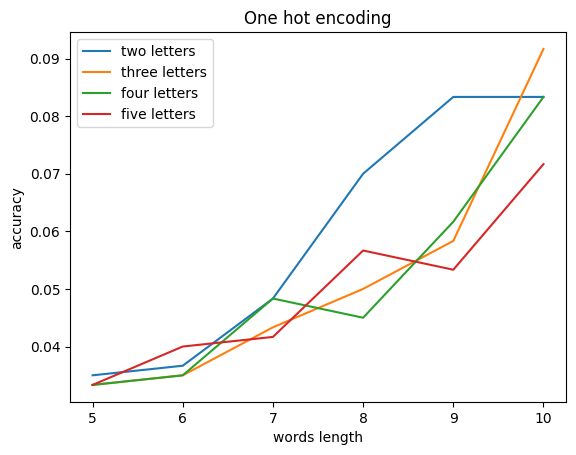

In [27]:
acc_1H.plot(title='One hot encoding', xlabel='words length', ylabel = 'accuracy')

<Axes: title={'center': 'One hot encoding'}, xlabel='words length', ylabel='distance (letters)'>

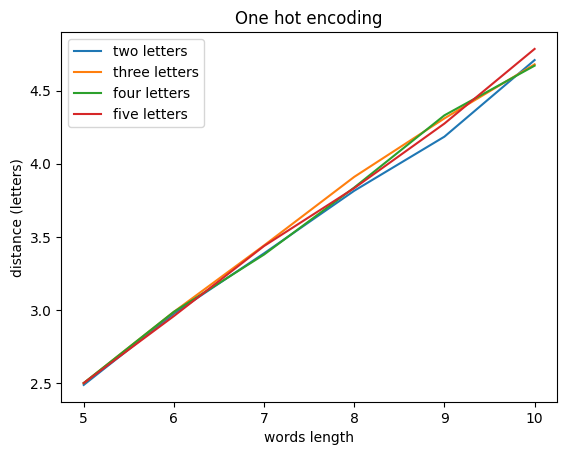

In [28]:
avg_1H.plot(title='One hot encoding', xlabel='words length', ylabel = 'distance (letters)')

<Axes: title={'center': 'ASCII encoding'}, xlabel='words length', ylabel='accuracy'>

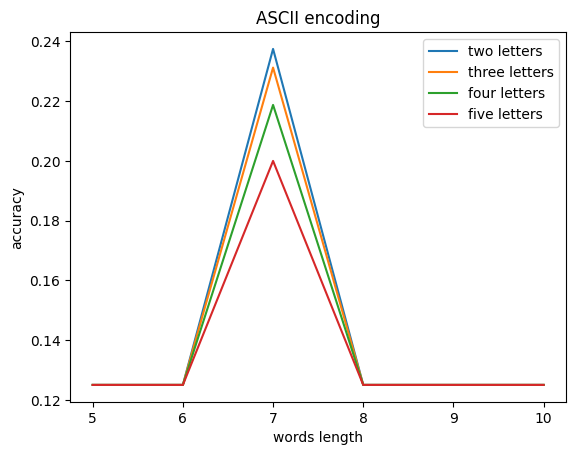

In [29]:
acc_ii.plot(title='ASCII encoding', xlabel='words length', ylabel = 'accuracy')

<Axes: title={'center': 'ASCII encoding'}, xlabel='words length', ylabel='distance (letters)'>

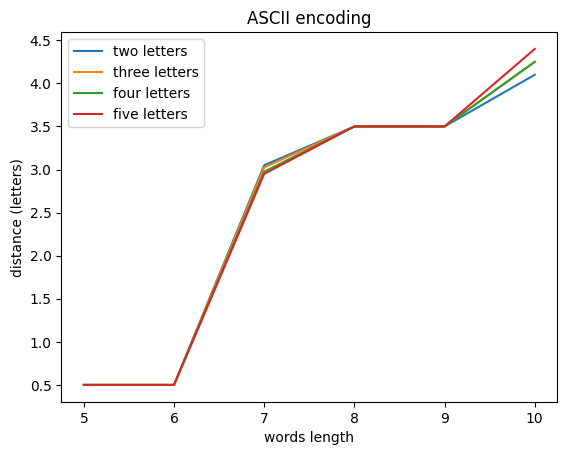

In [30]:
avg_ii.plot(title='ASCII encoding', xlabel='words length', ylabel = 'distance (letters)')

In [31]:
acc_1H_100.plot(title='One hot encoding', xlabel='words length (n=100)', ylabel = 'accuracy')

NameError: ignored

> <ipython-input-31-db98b94a4ac9>(1)<cell line: 1>()
----> 1 acc_1H_100.plot(title='One hot encoding', xlabel='words length (n=100)', ylabel = 'accuracy')




PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.10/bdb.py", line 361, in set_quit
    sys.settrace(None)


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/debugger.py", line 1075, in cmdloop
    sys.settrace(None)



--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user


<Axes: title={'center': 'One hot encoding'}, xlabel='words length (n=100)', ylabel='distance (letters)'>

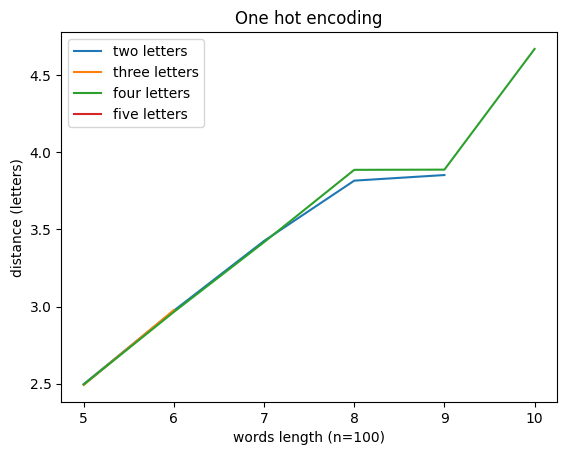

In [ ]:
avg_1H_100.plot(title='One hot encoding', xlabel='words length (n=100)', ylabel = 'distance (letters)')

<Axes: title={'center': 'ASCII encoding'}, xlabel='words length (n=100)', ylabel='accuracy'>

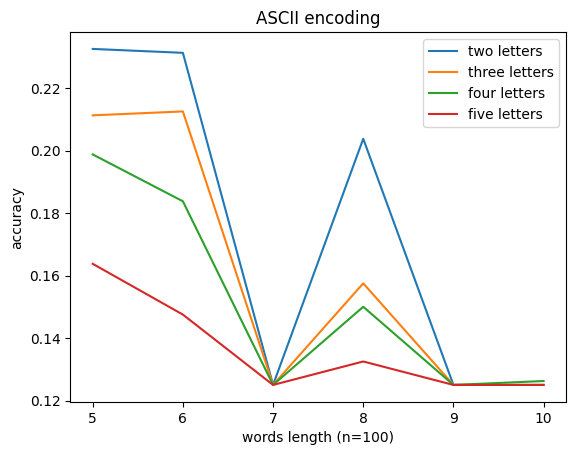

In [ ]:
acc_ii_100.plot(title='ASCII encoding', xlabel='words length (n=100)', ylabel = 'accuracy')

<Axes: title={'center': 'ASCII encoding'}, xlabel='words length (n=100)', ylabel='distance (letters)'>

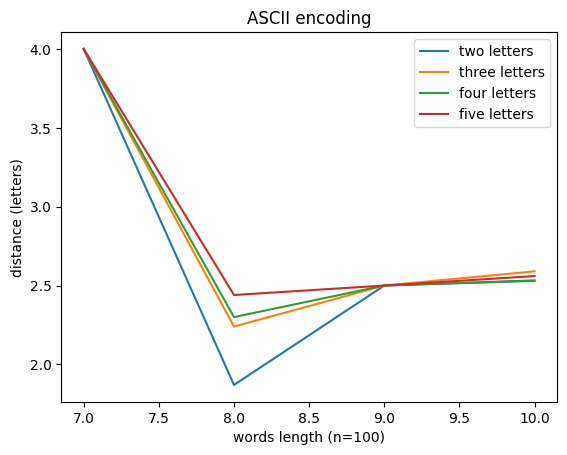

In [ ]:
avg_ii_100.plot(title='ASCII encoding', xlabel='words length (n=100)', ylabel = 'distance (letters)')

In [ ]:
acc_1H_100, avg_1H_100, nrg_1H_100 = run_experiment([5,6,7,8,9,10],
                                        word_to_matrix,
                                        scramblings,
                                        100)
acc_ii_100, avg_ii_100, nrg_ii_100 = run_experiment([5,6,7,8,9,10],
                                        convert_to_binary_array,
                                        scramblings,
                                        100)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# compare binarization method accuracy again using lite scrambling

acc_1H, avg_1H, nrg_1H = scrambling_accuracy(train_dict, scramble, (2,), word_to_matrix)

acc_ii, avg_ii, nrg_ii = scrambling_accuracy(train_dict, scramble, (2,), convert_to_binary_array)

print( str(acc_1H) + ' is the accuracy for the one-hot encoding, versus ' + str(acc_ii) + ' for the ascii encoding.')

# come up with more scramble methods
#   compare scramble methods

Gunnar:  If you run the bit above comparing binarizations, you see that for one-hot encoding the accuracy never rises above 0.2, but ascii I have seen vary from 0.2 to 0.8 by running it a whole bunch myself.

I failed to plot this or even run it for however many trials and print an average. I thought that would be easy but I couldn't figure out the errors about the dimensions of the arrays and I got very angry, started breaking things, and lost a lot of sleep. Not worth it anymore.

In [ ]:
data = pd.DataFrame(index = [3,4,5], columns = ('full', 'mid'))

In [ ]:
data['full'][3] = 1

In [ ]:
data['mid'][4] = 2